<a href="https://colab.research.google.com/github/Naima-ai/Codsoft/blob/main/movie_genre.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install nlpaug

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 3.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import re
from nltk.corpus import stopwords
import nltk
import nlpaug.augmenter.word as naw
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier

In [ ]:
#store data
training_path="/content/drive/MyDrive/archive (2)/Genre Classification Dataset/train_data.txt"
train_dt=pd.read_csv(training_path, sep=":::", names=["TITLE", "GENRE", "DESCRIPTION"], engine="python")

In [ ]:
train_dt

,TITLE,GENRE,DESCRIPTION
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...
2,Cupid (1997),thriller,A brother and sister with a past incestuous r...
3,"Young, Wild and Wonderful (1980)",adult,As the bus empties the students for their fie...
4,The Secret Sin (1915),drama,To help their unemployed father make ends mee...
5,The Unrecovered (2007),drama,The film's title refers not only to the un-re...
...,...,...,...
54210,"""Bonino"" (1953)",comedy,This short-lived NBC live sitcom centered on ...
54211,Dead Girls Don't Cry (????),horror,The NEXT Generation of EXPLOITATION. The sist...
54212,Ronald Goedemondt: Ze bestaan echt (2008),documentary,"Ze bestaan echt, is a stand-up comedy about g..."
54213,Make Your Own Bed (1944),comedy,Walter and Vivian live in the country and hav...


In [ ]:
testing_path="/content/drive/MyDrive/archive (2)/Genre Classification Dataset/test_data.txt"
test_dt=pd.read_csv(testing_path, sep=":::", names=["TITLE","DESCRIPTION"], engine="python")



In [ ]:
train_dt.shape
train_dt.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 54214 entries, 1 to 54214
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   TITLE        54214 non-null  object
 1   GENRE        54214 non-null  object
 2   DESCRIPTION  54214 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


In [ ]:
test_dt.shape
test_dt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54200 entries, 1 to 54200
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   TITLE        54200 non-null  object
 1   DESCRIPTION  54200 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [ ]:
test_dt.head()

,TITLE,DESCRIPTION
1,Edgar's Lunch (1998),"L.R. Brane loves his life - his car, his apar..."
2,La guerra de papá (1977),"Spain, March 1964: Quico is a very naughty ch..."
3,Off the Beaten Track (2010),One year in the life of Albin and his family ...
4,Meu Amigo Hindu (2015),"His father has died, he hasn't spoken with hi..."
5,Er nu zhai (1955),Before he was known internationally as a mart...


In [ ]:
#data preprocessing
from nltk.corpus import stopwords

nltk.download('stopwords')

stp = stopwords.words('english')

def clean_text(text):
    # Check if the input is a string or bytes-like object
    if not isinstance(text, (str, bytes)):
        return text

    text = text.lower()

    # Mentions
    text = re.sub(r'@\S+', '', text)

    # Punctuations
    text = re.sub(r'[^\w\s]', '', text)

    # Remove links
    text = re.sub(r'http\S+', '', text)

    # Remove unnecessary spaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove single characters
    text = re.sub(r'\b\w\b', '', text)

    # Remove unknown email addresses
    text = re.sub(r'\b\S+@\S+\.\S+\b', '', text)

    words = nltk.tokenize.word_tokenize(text, language="english", preserve_line=True)
    filtered_words = [word for word in words if word.lower() not in stp and len(word) > 2]
    cleaned_text = " ".join(filtered_words)


    return cleaned_text

# Load and clean the training data
train_dt["Clean_desc"] = train_dt["DESCRIPTION"].apply(clean_text)

# Load and clean the test data
test_dt["Clean_desc"] = test_dt["DESCRIPTION"].apply(clean_text)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
train_dt.info()
train_dt.head(1)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54214 entries, 1 to 54214
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   TITLE        54214 non-null  object
 1   GENRE        54214 non-null  object
 2   DESCRIPTION  54214 non-null  object
 3   Clean_desc   54214 non-null  object
dtypes: object(4)
memory usage: 2.1+ MB


,TITLE,GENRE,DESCRIPTION,Clean_desc
1,Oscar et la dame rose (2009),drama,Listening in to a conversation between his do...,listening conversation doctor parents 10yearol...


In [ ]:
#data augmentation
# Function for text augmentation
def augment_text(text):
    aug = naw.SynonymAug(aug_src='wordnet')
    augmented_text = aug.augment(text)
    if pd.isna(augmented_text):
        augmented_text = text
    return augmented_text

# Apply augmentation to the training data
train_dt["Augmented_desc"] = train_dt["Clean_desc"].apply(augment_text)
test_dt["Augmented_desc"] = test_dt["Clean_desc"].apply(augment_text)

train_dt["Augmented_desc"].fillna("default_value", inplace=True)

test_dt["Augmented_desc"].fillna("default_value", inplace=True)


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [ ]:
train_dt['Preprocess Data'] = train_dt.apply(lambda row: f"{row['Clean_desc']} {row['Augmented_desc']}" if not pd.isna(row['Augmented_desc']) else row['Clean_desc'], axis=1)


In [ ]:
train_dt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54214 entries, 1 to 54214
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   TITLE            54214 non-null  object
 1   GENRE            54214 non-null  object
 2   DESCRIPTION      54214 non-null  object
 3   Clean_desc       54214 non-null  object
 4   Augmented_desc   54214 non-null  object
 5   Preprocess Data  54214 non-null  object
dtypes: object(6)
memory usage: 2.9+ MB


In [ ]:
train_dt['Preprocess Data']

1        listening conversation doctor parents 10yearol...
2        brother sister past incestuous relationship cu...
3        bus empties students field trip museum natural...
4        help unemployed father make ends meet edith tw...
5        films title refers unrecovered bodies ground z...
                               ...                        
54210    shortlived nbc live sitcom centered bonino wor...
54211    next generation exploitation sisters kapa bay ...
54212    bestaan echt standup comedy growing facing fea...
54213    walter vivian live country difficult time keep...
54214    labor day weekend 1935 intense hurricane ever ...
Name: Preprocess Data, Length: 54214, dtype: object

In [ ]:
test_dt['input'] = test_dt.apply(lambda row: f"{row['TITLE']} {row['Clean_desc']} {row['Augmented_desc']}" if not pd.isna(row['Augmented_desc']) else f"{row['TITLE']} {row['Clean_desc']}", axis=1)


In [ ]:
test_dt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 54200 entries, 1 to 54200
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   TITLE           54200 non-null  object
 1   DESCRIPTION     54200 non-null  object
 2   Clean_desc      54200 non-null  object
 3   Augmented_desc  54200 non-null  object
 4   input           54200 non-null  object
dtypes: object(5)
memory usage: 2.5+ MB


In [ ]:
test_dt['input']

1         Edgar's Lunch (1998)  brane loves life car ap...
2         La guerra de papá (1977)  spain march 1964 qu...
3         Off the Beaten Track (2010)  one year life al...
4         Meu Amigo Hindu (2015)  father died hasnt spo...
5         Er nu zhai (1955)  known internationally mart...
                               ...                        
54196     "Tales of Light & Dark" (2013)  covering mult...
54197     Der letzte Mohikaner (1965)  alice cora munro...
54198     Oliver Twink (2007)  movie 169 years making o...
54199     Slipstream (1973)  popular mysterious rock mi...
54200     Curitiba Zero Grau (2010)  curitiba city move...
Name: input, Length: 54200, dtype: object

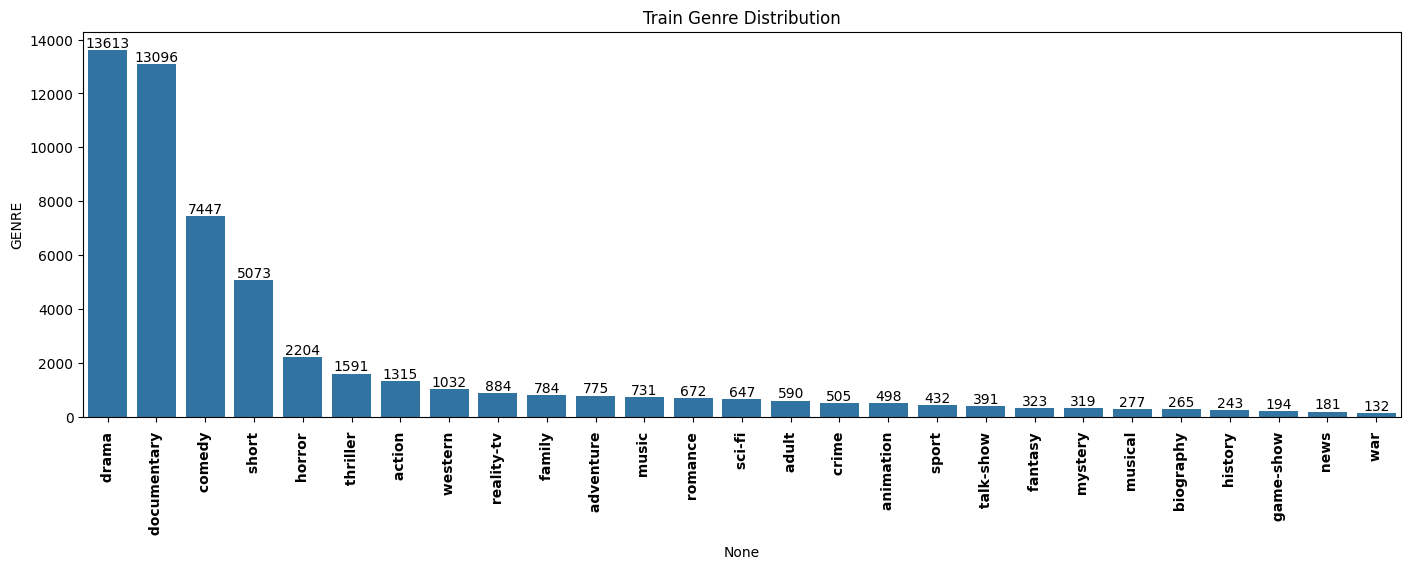

In [ ]:
plt.subplots(figsize=(17, 5))
ax1 = sns.barplot(x=train_dt["GENRE"].value_counts().index,
            y=train_dt["GENRE"].value_counts())
ax1.bar_label(ax1.containers[0])
plt.title("Train Genre Distribution")
plt.xticks(rotation=90,fontweight="bold")
plt.show()

In [ ]:
#vectorize
vectorizer = TfidfVectorizer(stop_words='english')
train_vectors = vectorizer.fit_transform(train_dt['Preprocess Data'])
test_vectors=vectorizer.transform(test_dt['input'])

In [ ]:
train_vectors

<54214x156154 sparse matrix of type '<class 'numpy.float64'>'
	with 2808669 stored elements in Compressed Sparse Row format>

In [ ]:
test_vectors

<54200x156154 sparse matrix of type '<class 'numpy.float64'>'
	with 2831897 stored elements in Compressed Sparse Row format>

In [ ]:
vocab= vectorizer.vocabulary_


In [ ]:
vocab

In [ ]:
from imblearn.over_sampling import RandomOverSampler

sampler = RandomOverSampler(random_state=42)
train_vectors_resampled, test_vectors_resampled = sampler.fit_resample(
    train_vectors, train_dt['GENRE'])

In [ ]:
train_vectors_resampled,test_vectors_resampled

(<367551x156154 sparse matrix of type '<class 'numpy.float64'>'
 	with 18573658 stored elements in Compressed Sparse Row format>,
 0             drama 
 1          thriller 
 2             adult 
 3             drama 
 4             drama 
              ...    
 367546      western 
 367547      western 
 367548      western 
 367549      western 
 367550      western 
 Name: GENRE, Length: 367551, dtype: object)

In [ ]:
plt.subplots(figsize=(17, 5))
sns.countplot(data=test_vectors_resampled,x=test_vectors_resampled.values)
plt.title("Train Genre Distribution")
plt.xticks(rotation=90,fontweight="bold")
plt.show()


In [ ]:
train_dt["GENRE"].unique(),train_dt["GENRE"].unique().shape

(array([' drama ', ' thriller ', ' adult ', ' documentary ', ' comedy ',
        ' crime ', ' reality-tv ', ' horror ', ' sport ', ' animation ',
        ' action ', ' fantasy ', ' short ', ' sci-fi ', ' music ',
        ' adventure ', ' talk-show ', ' western ', ' family ', ' mystery ',
        ' history ', ' news ', ' biography ', ' romance ', ' game-show ',
        ' musical ', ' war '], dtype=object),
 (27,))

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    train_vectors_resampled, test_vectors_resampled, test_size=0.3, random_state=42
)



In [ ]:
# Label encoding
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)


In [ ]:

from sklearn.preprocessing import LabelEncoder

# Multinomial Naive Bayes
model_nb = MultinomialNB()
model_nb.fit(X_train, y_train_encoded)
y_pred_nb = model_nb.predict(X_val)
accuracy_nb = accuracy_score(y_val_encoded, y_pred_nb)
print(f"Multinomial Naive Bayes Accuracy on the validation set: {accuracy_nb:.2%}")

# Random Forest
model_rf = RandomForestClassifier(n_estimators=100, max_depth=None, min_samples_split=2, n_jobs=-1, random_state=42)
model_rf.fit(X_train, y_train_encoded)
y_pred_rf = model_rf.predict(X_val)
accuracy_rf = accuracy_score(y_val_encoded, y_pred_rf)
print(f"Random Forest Accuracy on the validation set: {accuracy_rf:.2%}")

# Load the correct genres from the test_data_solution.txt file
solution_path = "/content/drive/MyDrive/archive (2)/Genre Classification Dataset/test_data_solution.txt"
test_solution = pd.read_csv(solution_path, sep=":::", names=["TITLE", "GENRE", "DESCRIPTION"], engine="python")

test_result = test_solution.merge(test_dt[['TITLE']], on='TITLE', how='inner')
test_result['Predicted_GENRE_NB'] = label_encoder.inverse_transform(model_nb.predict(test_vectors))
test_result['Predicted_GENRE_RF'] = label_encoder.inverse_transform(model_rf.predict(test_vectors))

# Validate the accuracy on the test set
test_accuracy_nb = accuracy_score(test_result['GENRE'], test_result['Predicted_GENRE_NB'])
test_accuracy_rf = accuracy_score(test_result['GENRE'], test_result['Predicted_GENRE_RF'])

print(f"Accuracy on the test set (Multinomial Naive Bayes): {test_accuracy_nb:.2%}")
print(f"Accuracy on the test set (Random Forest): {test_accuracy_rf:.2%}")
#print("\nClassification Report on the test set (Multinomial Naive Bayes):")
#print(classification_report(test_result['GENRE'], test_result['Predicted_GENRE_NB']))
print("\nClassification Report on the test set (Random Forest):")
print(classification_report(test_result['GENRE'], test_result['Predicted_GENRE_RF']))





Multinomial Naive Bayes Accuracy on the validation set: 91.56%
Random Forest Accuracy on the validation set: 97.02%
Accuracy on the test set (Multinomial Naive Bayes): 50.65%
Accuracy on the test set (Random Forest): 50.97%

Classification Report on the test set (Random Forest):


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


               precision    recall  f1-score   support

      action        0.64      0.07      0.12      1314
       adult        0.54      0.29      0.38       590
   adventure        0.71      0.13      0.23       775
   animation        0.46      0.02      0.05       498
   biography        0.00      0.00      0.00       264
      comedy        0.44      0.39      0.41      7446
       crime        0.50      0.02      0.03       505
 documentary        0.58      0.81      0.68     13096
       drama        0.46      0.74      0.56     13612
      family        0.81      0.03      0.05       783
     fantasy        0.50      0.01      0.01       322
   game-show        0.79      0.58      0.66       193
     history        0.50      0.01      0.02       243
      horror        0.54      0.40      0.46      2204
       music        0.55      0.48      0.51       731
     musical        0.29      0.03      0.05       276
     mystery        1.00      0.00      0.01       318
        n

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
test_result.head()

,TITLE,GENRE,DESCRIPTION,Predicted_GENRE_NB,Predicted_GENRE_RF
0,Edgar's Lunch (1998),thriller,"L.R. Brane loves his life - his car, his apar...",comedy,drama
1,La guerra de papá (1977),comedy,"Spain, March 1964: Quico is a very naughty ch...",drama,drama
2,Off the Beaten Track (2010),documentary,One year in the life of Albin and his family ...,documentary,documentary
3,Meu Amigo Hindu (2015),drama,"His father has died, he hasn't spoken with hi...",drama,drama
4,Er nu zhai (1955),drama,Before he was known internationally as a mart...,action,drama


In [ ]:
print(X_val)

In [ ]:
y_train.head(5)

In [ ]:
y_val.head(5)

In [ ]:
svm= SGDClassifier()
svm.fit(X_train,y_train_encoded)

SGDClassifier()

In [ ]:
y_pred_svm = svm.predict(X_val)
accuracy_svm = accuracy_score(y_val_encoded, y_pred_svm)
print(f"Multinomial SVM Accuracy on the validation set: {accuracy_svm:.2%}")

Multinomial SVM Accuracy on the validation set: 86.67%
